### Demonstration of Distributionally Robust Explanations (DRE) Visualization Results

The results are compared with Empirical Risk Minimization (ERM) on the "Dog" class in the Terra Incognita dataset. The model is trained on Locations 100, 38, and 43, uses Location 46 as the out-of-distribution testing set. You can simply run all cells to access the results.

### 0. Load Libraries

In [1]:
import sys
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.models
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from captum.attr import LayerGradCam
from PIL import Image

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 1. Utils

In [2]:
class ResNet(torch.nn.Module):
    """ResNet with the softmax chopped off and the batchnorm frozen"""
    def __init__(self):
        super(ResNet, self).__init__()
        self.network = torchvision.models.resnet50()
        self.n_outputs = 2048
        self.freeze_bn()
        self.dropout = nn.Dropout(p=0.0)
        self.network.fc = nn.Linear(self.network.fc.in_features, 10)

    def forward(self, x):
        """Encode x into a feature vector of size n_outputs."""
        return self.dropout(self.network(x))

    def train(self, mode=True):
        """
        Override the default train() to freeze the BN parameters
        """
        super().train(mode)
        self.freeze_bn()

    def freeze_bn(self):
        for m in self.network.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

def attr_scale(x):
    return (x-x.min()) / (x.max()-x.min())

### 2. Load Pretrained Weights

In [3]:
net_base = ResNet()
net_base = nn.DataParallel(net_base)
net_base.load_state_dict(torch.load('./ckpts/model_ERM.pth'))
net_base = net_base.to(device)
net_base.eval()

net_ours = ResNet()
net_ours = nn.DataParallel(net_ours)
net_ours.load_state_dict(torch.load('./ckpts/model_DRE.pth'))
net_ours = net_ours.to(device)
net_ours.eval()

DataParallel(
  (module): ResNet(
    (network): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

### 2. Load Example Data

In [4]:
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

transform_orig = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()
        ])

In [5]:
image_names = ['L100', 'L38', 'L43', 'L46']

image = Image.open('./data/{}.jpg'.format(image_names[0]))
inputs = transform(image).unsqueeze_(0)
inputs_orig = transform_orig(image).unsqueeze_(0)

for i in range(1, 4):
    image = Image.open('./data/{}.jpg'.format(image_names[i]))

    input = transform(image).unsqueeze_(0)
    input_orig = transform_orig(image).unsqueeze_(0)

    inputs = torch.cat((inputs, input), 0)
    inputs_orig = torch.cat((inputs_orig, input_orig), 0)

### 3. Explain the Examples

In [6]:
def explain(images, images_orig, net_base, net_ours, device, imgsz=224):
    origins = []
    heatmaps_base = []
    heatmaps_ours = []

    layer_gc_base = LayerGradCam(net_base, net_base.module.network.layer4)
    layer_gc_ours = LayerGradCam(net_ours, net_ours.module.network.layer4)

    images = images.to(device)

    outputs_base = net_base(images)
    outputs_ours = net_ours(images)

    preds_base = outputs_base.argmax(dim=1)
    preds_ours = outputs_ours.argmax(dim=1)

    for i in range(len(images)):
        image = images[i].reshape(1, 3, imgsz, imgsz).to(device)
        image_orig = images_orig[i].reshape(1, 3, imgsz, imgsz).to(device)

        attr_base = layer_gc_base.attribute(image, target=preds_base[i])
        attr_ours = layer_gc_ours.attribute(image, target=preds_ours[i])

        attribution_base = F.interpolate(attr_base, size=imgsz, mode='bilinear').squeeze()
        attribution_ours = F.interpolate(attr_ours, size=imgsz, mode='bilinear').squeeze()

        attribution_base = attr_scale(attribution_base)
        attribution_ours = attr_scale(attribution_ours)

        cmap = mpl.cm.get_cmap('jet', 256)
        heatmap_base = cmap(attribution_base.cpu().detach().numpy(), alpha = 0.5)
        heatmap_ours = cmap(attribution_ours.cpu().detach().numpy(), alpha = 0.5)

        origins.append(images_orig[i].squeeze().cpu().detach().numpy().transpose(1, 2, 0))
        heatmaps_base.append(heatmap_base)
        heatmaps_ours.append(heatmap_ours)

    return origins, heatmaps_base, heatmaps_ours
    
origins, heatmaps_base, heatmaps_ours = explain(inputs, inputs_orig, net_base, net_ours, device)

### 4. Plot the Results

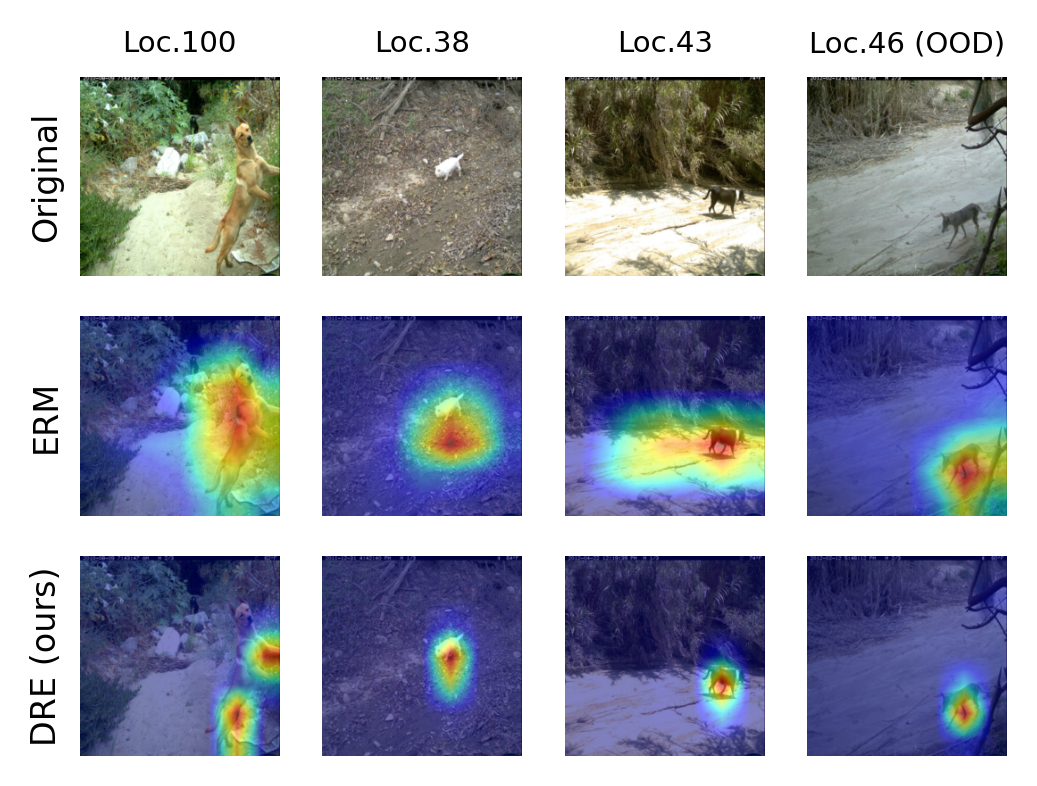

In [7]:
row = 3
col = 4
fig, axs = plt.subplots(row, col, figsize=(4, 3), dpi=300)
titles = ['Loc.100', 'Loc.38', 'Loc.43', 'Loc.46 (OOD)']
ylabels = ['Original', 'ERM', 'DRE (ours)']
fig.patch.set_facecolor('white')

for i in range(row):
    for j in range(col):
        axs[i, j].imshow(origins[j])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].spines['top'].set_visible(False)
        axs[i, j].spines['right'].set_visible(False)
        axs[i, j].spines['bottom'].set_visible(False)
        axs[i, j].spines['left'].set_visible(False)
        
        if i == 0:
            axs[i, j].set_title(titles[j], fontsize=7)
        if j == 0:
            axs[i, j].set_ylabel(ylabels[i], fontsize=8)

        if i == 1:
            axs[i, j].imshow(heatmaps_base[j])
        if i == 2:
            axs[i, j].imshow(heatmaps_ours[j])

Expected Output:

<img src="figures/expect_output.png" width="800" height="600">